# 노면 검출 (Ground Detection)

이 노트북에서는 LiDAR 포인트 클라우드에서 노면(지면)을 검출하는 다양한 알고리즘을 살펴보고 구현합니다.

## 학습 목표

- 노면 검출의 중요성과 활용 방법 이해
- RANSAC 기반 노면 검출 구현 및 이해
- 높이 기반 노면 검출 구현 및 이해
- 노면 제거를 통한 장애물 세그멘테이션
- 노면 모델링 및 파라미터 추정

## 1. 필요한 라이브러리 설치 및 임포트

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor
import os
import sys

if 'XDG_RUNTIME_DIR' not in os.environ:
    os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-user'
    # 필요하면 디렉토리 생성
    os.makedirs('/tmp/runtime-user', exist_ok=True)

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.ground_detection import (
    ransac_ground_detection,
    height_threshold_ground_detection,
    adaptive_height_threshold,
    remove_ground_points,
    extract_ground_points,
    estimate_ground_plane
)

from utils.visualization import (
    visualize_point_cloud,
    visualize_ground,
    plot_bev
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## 2. 데이터 로드

KITTI 데이터셋에서 포인트 클라우드를 로드합니다.

In [2]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

# 데이터 경로 설정
# data_dir = '../../data/kitti'
data_dir = os.path.join(parent_dir, 'data')
point_cloud_dir = os.path.join(data_dir, 'velodyne_points')

# 첫 번째 프레임 로드
frame_id = '0000000000'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')

# 포인트 클라우드 로드
if os.path.exists(point_cloud_path):
    points = load_point_cloud(point_cloud_path)
    print(f"포인트 클라우드 로드 완료: {points.shape}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print(f"경로에 데이터가 없습니다: {point_cloud_path}")
    print("예시 데이터를 생성합니다...")
    
    # 예시 데이터 생성 (간단한 지면과 장애물)
    x = np.random.uniform(-30, 30, 10000)
    y = np.random.uniform(-30, 30, 10000)
    
    # 지면 생성 (약간 경사진 평면)
    ground_z = -0.1 * x + 0.05 * y - 1.8 + np.random.normal(0, 0.05, 10000)
    
    # 일부 포인트를 객체로 만들기
    object_indices = np.random.choice(10000, 2000, replace=False)
    object_heights = np.random.uniform(0.5, 3.0, 2000)
    
    z = ground_z.copy()
    z[object_indices] += object_heights
    
    # 강도 값 생성
    intensity = np.random.uniform(0, 1, 10000)
    
    # 최종 포인트 클라우드
    points = np.column_stack((x, y, z, intensity))
    print(f"예시 데이터 생성 완료: {points.shape}")

# 포인트 클라우드 통계 출력
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")


포인트 클라우드 로드 완료: (121438, 4)
포인트 개수: 121438
X 범위: [-78.60, 78.92]
Y 범위: [-63.40, 66.70]
Z 범위: [-25.25, 2.88]
강도 범위: [0.00, 0.99]


## 3. 포인트 클라우드 시각화

로드한 포인트 클라우드를 시각화합니다.


[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7912/1077033262.py:25: UserWar

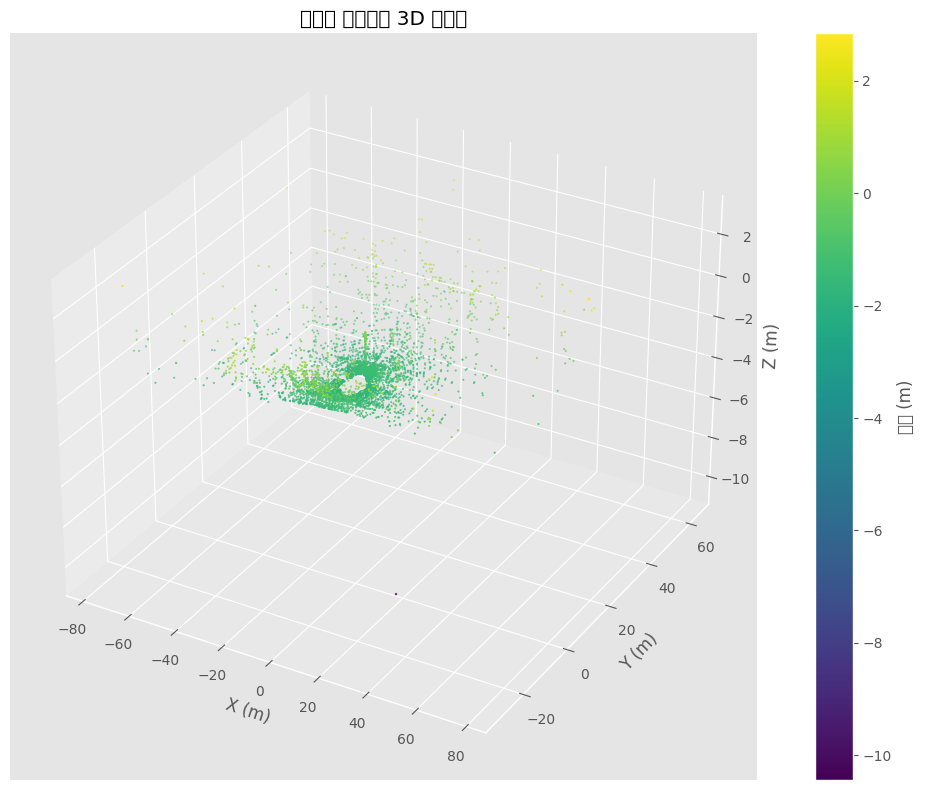

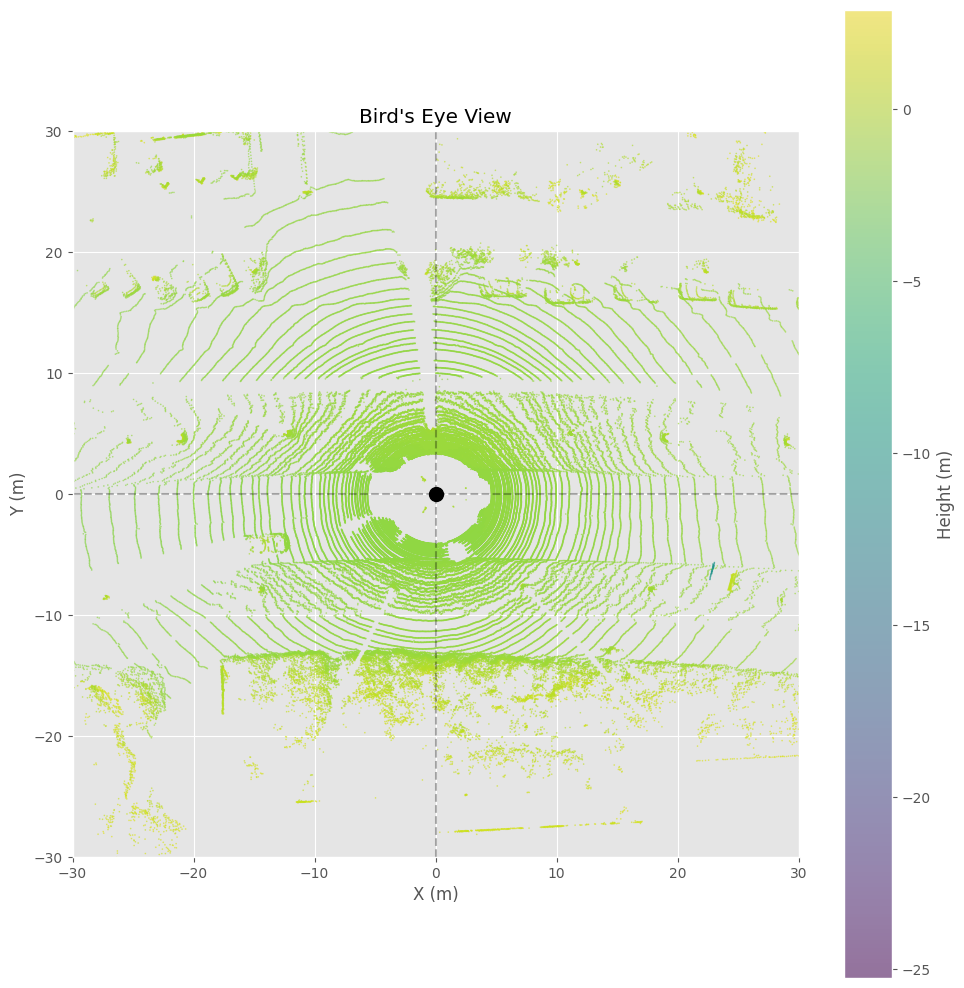

In [4]:
# 포인트 클라우드 시각화
vis = visualize_point_cloud(points)

# 3D 산점도 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 점 샘플링 (모든 점을 그리면 너무 많아서 느려짐)
sample_idx = np.random.choice(points.shape[0], 5000, replace=False)
sampled_points = points[sample_idx]

# 높이(z)에 따라 색상 지정
scatter = ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                     c=sampled_points[:, 2], cmap='viridis', s=1)

# 축 레이블 설정
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('포인트 클라우드 3D 시각화')

# 컬러바 추가
plt.colorbar(scatter, ax=ax, label='높이 (m)')

plt.tight_layout()
plt.show()

# 조감도(BEV) 시각화
fig = plot_bev(points, xlim=(-30, 30), ylim=(-30, 30))
plt.show()

## 4. 높이 기반 노면 검출

간단한 높이 임계값 방식으로 노면을 검출합니다. 이 방식은 계산이 빠르지만 경사면이나 복잡한 지형에는 적합하지 않습니다.


전체 포인트 개수: 121438
지면 포인트 개수: 25087
지면 포인트 비율: 20.66%
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


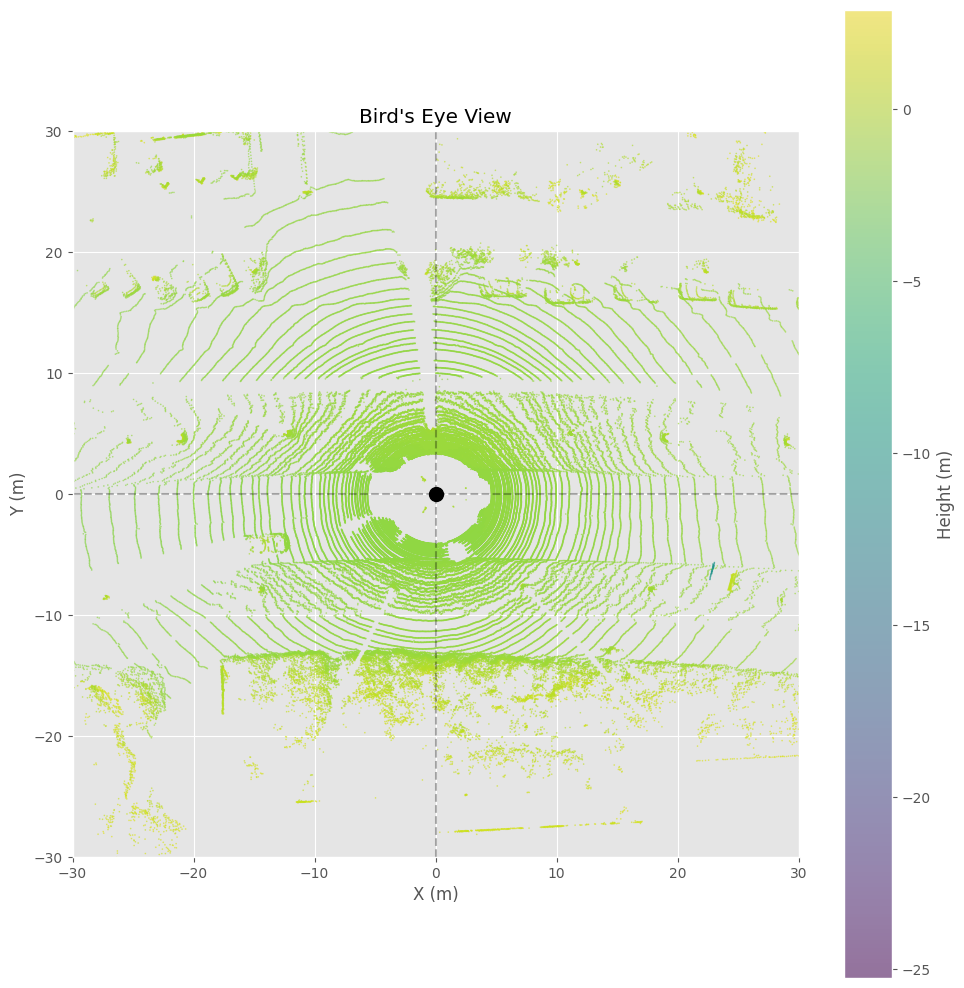

In [5]:
# 높이 임계값 기반 지면 검출
height_threshold = 0.3  # 높이 임계값 (m)
percentile = 1.0  # 하위 1% 포인트를 기준으로 설정

# 지면 검출
ground_mask = height_threshold_ground_detection(
    points, height_thresh=height_threshold, percentile=percentile)

# 검출된 지면 포인트 개수 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"지면 포인트 개수: {np.sum(ground_mask)}")
print(f"지면 포인트 비율: {np.sum(ground_mask) / points.shape[0] * 100:.2f}%")

# 시각화
visualize_ground(points, ground_mask)

# 조감도로 지면/비지면 시각화
fig = plot_bev(points, ground_mask=ground_mask, xlim=(-30, 30), ylim=(-30, 30))
plt.show()


높이 기반 방식을 확장하여 적응형 높이 임계값 방식을 구현해 봅시다. 이 방법은 영역을 격자로 나누어 각 영역마다 다른 높이 임계값을 적용합니다.

In [ ]:
# 적응형 높이 임계값 적용
grid_size = 1.0  # 격자 크기 (m)
adaptive_height_thresh = 0.2  # 각 격자 내에서의 높이 임계값
min_points_per_cell = 5  # 유효한 격자 셀의 최소 포인트 수

# 적응형 지면 검출
adaptive_ground_mask = adaptive_height_threshold(
    points, grid_size=grid_size, 
    height_thresh=adaptive_height_thresh,
    min_points_per_cell=min_points_per_cell
)

# 결과 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"적응형 지면 포인트 개수: {np.sum(adaptive_ground_mask)}")
print(f"적응형 지면 포인트 비율: {np.sum(adaptive_ground_mask) / points.shape[0] * 100:.2f}%")

# 시각화
visualize_ground(points, adaptive_ground_mask)

# 조감도로 지면/비지면 시각화
fig = plot_bev(points, ground_mask=adaptive_ground_mask, xlim=(-30, 30), ylim=(-30, 30))
plt.show()


## 5. RANSAC 기반 노면 검출

RANSAC(RANdom SAmple Consensus)은 이상치(outlier)에 강인한 모델 피팅 알고리즘입니다. 노면을 평면으로 모델링하고 RANSAC을 사용하여 피팅합니다.


In [ ]:
# RANSAC 파라미터 설정
distance_thresh = 0.15  # 인라이어로 간주하는 평면과의 최대 거리 (m)
max_iterations = 100  # RANSAC 최대 반복 횟수

# RANSAC 기반 지면 검출
ransac_ground_mask, ransac_model = ransac_ground_detection(
    points, distance_thresh=distance_thresh, 
    max_iterations=max_iterations, return_model=True
)

# 결과 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"RANSAC 지면 포인트 개수: {np.sum(ransac_ground_mask)}")
print(f"RANSAC 지면 포인트 비율: {np.sum(ransac_ground_mask) / points.shape[0] * 100:.2f}%")

# 평면 모델 파라미터 출력
normal = ransac_model['normal']
intercept = ransac_model['intercept']
print(f"지면 평면 방정식: {normal[0]:.4f}x + {normal[1]:.4f}y + {normal[2]:.4f}z + {intercept:.4f} = 0")

# 지면 법선 벡터의 수직 각도 계산 (degrees)
vertical_angle = np.arccos(np.abs(normal[2])) * 180 / np.pi
print(f"지면 기울기 (수직에서): {vertical_angle:.2f}°")

# 시각화
visualize_ground(points, ransac_ground_mask)

# 조감도로 지면/비지면 시각화
fig = plot_bev(points, ground_mask=ransac_ground_mask, xlim=(-30, 30), ylim=(-30, 30))
plt.show()

## 6. 노면 제거 및 장애물 추출

노면을 제거하면 장애물만 남게 되어 객체 검출의 전처리 단계로 활용할 수 있습니다.

In [ ]:
# 노면 제거
non_ground_points = remove_ground_points(points, ransac_ground_mask)
print(f"비노면 포인트 개수: {non_ground_points.shape[0]}")

# 노면만 추출
ground_points = extract_ground_points(points, ransac_ground_mask)
print(f"노면 포인트 개수: {ground_points.shape[0]}")

# 비노면 포인트 시각화
visualize_point_cloud(non_ground_points, window_name="Non-ground Points")

# 노면만 시각화
visualize_point_cloud(ground_points, window_name="Ground Points Only")

## 7. 다양한 지면 추정 방법 비교

여러 지면 추정 방법의 성능을 비교합니다.

In [ ]:
# 각 방법별 지면 추정 및 시각화 준비
methods = [
    ('Height Threshold', ground_mask),
    ('Adaptive Height Threshold', adaptive_ground_mask),
    ('RANSAC', ransac_ground_mask)
]

# 방법별 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (method_name, mask) in enumerate(methods):
    ground_ratio = np.sum(mask) / len(mask) * 100
    
    # 조감도 시각화
    colors = np.zeros((points.shape[0], 3))
    colors[mask] = [0.0, 0.8, 0.0]  # 녹색 (지면)
    colors[~mask] = [0.8, 0.0, 0.0]  # 빨간색 (비지면)
    
    axes[i].scatter(points[:, 0], points[:, 1], c=colors, s=0.5)
    axes[i].set_xlim([-30, 30])
    axes[i].set_ylim([-30, 30])
    axes[i].set_title(f"{method_name}\nGround: {ground_ratio:.1f}%")
    axes[i].set_aspect('equal')
    axes[i].set_xlabel('X (m)')
    
    if i == 0:
        axes[i].set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

## 8. 노면 특성 파악 및 분석

추출한 노면의 특성을 분석합니다. 이는 주행 가능 영역 분석, 지형 분류 등에 활용할 수 있습니다.


In [ ]:
# 노면 높이 분포 분석
ground_heights = ground_points[:, 2]

plt.figure(figsize=(10, 6))
plt.hist(ground_heights, bins=50, alpha=0.7)
plt.title('Ground Height Distribution')
plt.xlabel('Height (m)')
plt.ylabel('Number of Points')
plt.grid(True)
plt.show()

# 노면 강도(intensity) 분포 분석
ground_intensities = ground_points[:, 3]

plt.figure(figsize=(10, 6))
plt.hist(ground_intensities, bins=50, alpha=0.7)
plt.title('Ground Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Number of Points')
plt.grid(True)
plt.show()

# 노면 BEV Intensity 이미지 생성
# 이 작업은 utils.visualization의 plot_intensity_image 함수로 대체할 수도 있음
from utils.visualization import plot_intensity_image

fig = plot_intensity_image(ground_points, intensity=ground_points[:, 3], resolution=0.2)
plt.title('Ground Intensity BEV Image')
plt.show()

## 9. 고급: 노면 모델 피팅 및 분석

더 정교한 노면 모델을 피팅하고 분석합니다.

In [ ]:
# Open3D를 사용한 노면 분할
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:, :3])

# 평면 분할
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2,
                                         ransac_n=3,
                                         num_iterations=1000)

# 결과 출력
a, b, c, d = plane_model
print(f"Open3D 평면 방정식: {a:.4f}x + {b:.4f}y + {c:.4f}z + {d:.4f} = 0")

# 인라이어 마스크 생성
o3d_ground_mask = np.zeros(len(points), dtype=bool)
o3d_ground_mask[inliers] = True

print(f"Open3D 지면 포인트 개수: {np.sum(o3d_ground_mask)}")
print(f"Open3D 지면 포인트 비율: {np.sum(o3d_ground_mask) / points.shape[0] * 100:.2f}%")

# 시각화
visualize_ground(points, o3d_ground_mask)

# RANSAC 결과와 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RANSAC 결과
colors = np.zeros((points.shape[0], 3))
colors[ransac_ground_mask] = [0.0, 0.8, 0.0]  # 녹색 (지면)
colors[~ransac_ground_mask] = [0.8, 0.0, 0.0]  # 빨간색 (비지면)

axes[0].scatter(points[:, 0], points[:, 1], c=colors, s=0.5)
axes[0].set_xlim([-30, 30])
axes[0].set_ylim([-30, 30])
axes[0].set_title(f"RANSAC (sklearn)\nGround: {np.sum(ransac_ground_mask) / len(ransac_ground_mask) * 100:.1f}%")
axes[0].set_aspect('equal')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')

# Open3D 결과
colors = np.zeros((points.shape[0], 3))
colors[o3d_ground_mask] = [0.0, 0.8, 0.0]  # 녹색 (지면)
colors[~o3d_ground_mask] = [0.8, 0.0, 0.0]  # 빨간색 (비지면)

axes[1].scatter(points[:, 0], points[:, 1], c=colors, s=0.5)
axes[1].set_xlim([-30, 30])
axes[1].set_ylim([-30, 30])
axes[1].set_title(f"Open3D\nGround: {np.sum(o3d_ground_mask) / len(o3d_ground_mask) * 100:.1f}%")
axes[1].set_aspect('equal')
axes[1].set_xlabel('X (m)')

plt.tight_layout()
plt.show()

## 10. 실습: 다양한 시나리오에서의 노면 검출

여러 프레임의 데이터에 대해 노면 검출을 수행해 봅시다.

In [ ]:
# 여러 프레임 처리 함수
def process_multiple_frames(frame_ids, method='ransac'):
    results = []
    
    for frame_id in frame_ids:
        # 포인트 클라우드 로드
        point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id:06d}.bin')
        if not os.path.exists(point_cloud_path):
            print(f"파일을 찾을 수 없음: {point_cloud_path}")
            continue
            
        points = load_point_cloud(point_cloud_path)
        
        # 노면 검출 (선택한 방법에 따라)
        if method == 'ransac':
            ground_mask, model = ransac_ground_detection(points, return_model=True)
        elif method == 'height':
            ground_mask = height_threshold_ground_detection(points)
        elif method == 'adaptive':
            ground_mask = adaptive_height_threshold(points)
        else:
            raise ValueError(f"지원하지 않는 방법: {method}")
            
        # 결과 저장
        results.append({
            'frame_id': frame_id,
            'points': points,
            'ground_mask': ground_mask,
            'ground_ratio': np.sum(ground_mask) / len(ground_mask) * 100,
            'model': model if method == 'ransac' else None
        })
        
        print(f"프레임 {frame_id} 처리 완료: 지면 비율 {results[-1]['ground_ratio']:.1f}%")
    
    return results

# 여러 프레임 처리
# KITTI 데이터가 있는 경우 사용
# frame_ids = [0, 10, 20, 30, 40]
# results = process_multiple_frames(frame_ids)

## 11. 요약 및 결론

이 노트북에서는 LiDAR 포인트 클라우드에서 노면을 검출하는 다양한 방법을 살펴보았습니다:

1. **높이 기반 방법**: 계산이 빠르지만 지형 변화에 취약합니다.
2. **적응형 높이 임계값**: 격자별로 다른 임계값을 적용하여 지형 변화에 더 강인합니다.
3. **RANSAC 기반 방법**: 이상치에 강인하고 더 정확한 평면 모델을 제공합니다.

노면 검출은 다양한 자율주행 인지 작업의 기초가 되며, 객체 검출, 도로 경계 추출, 주행 가능 영역 분석 등에 활용됩니다.